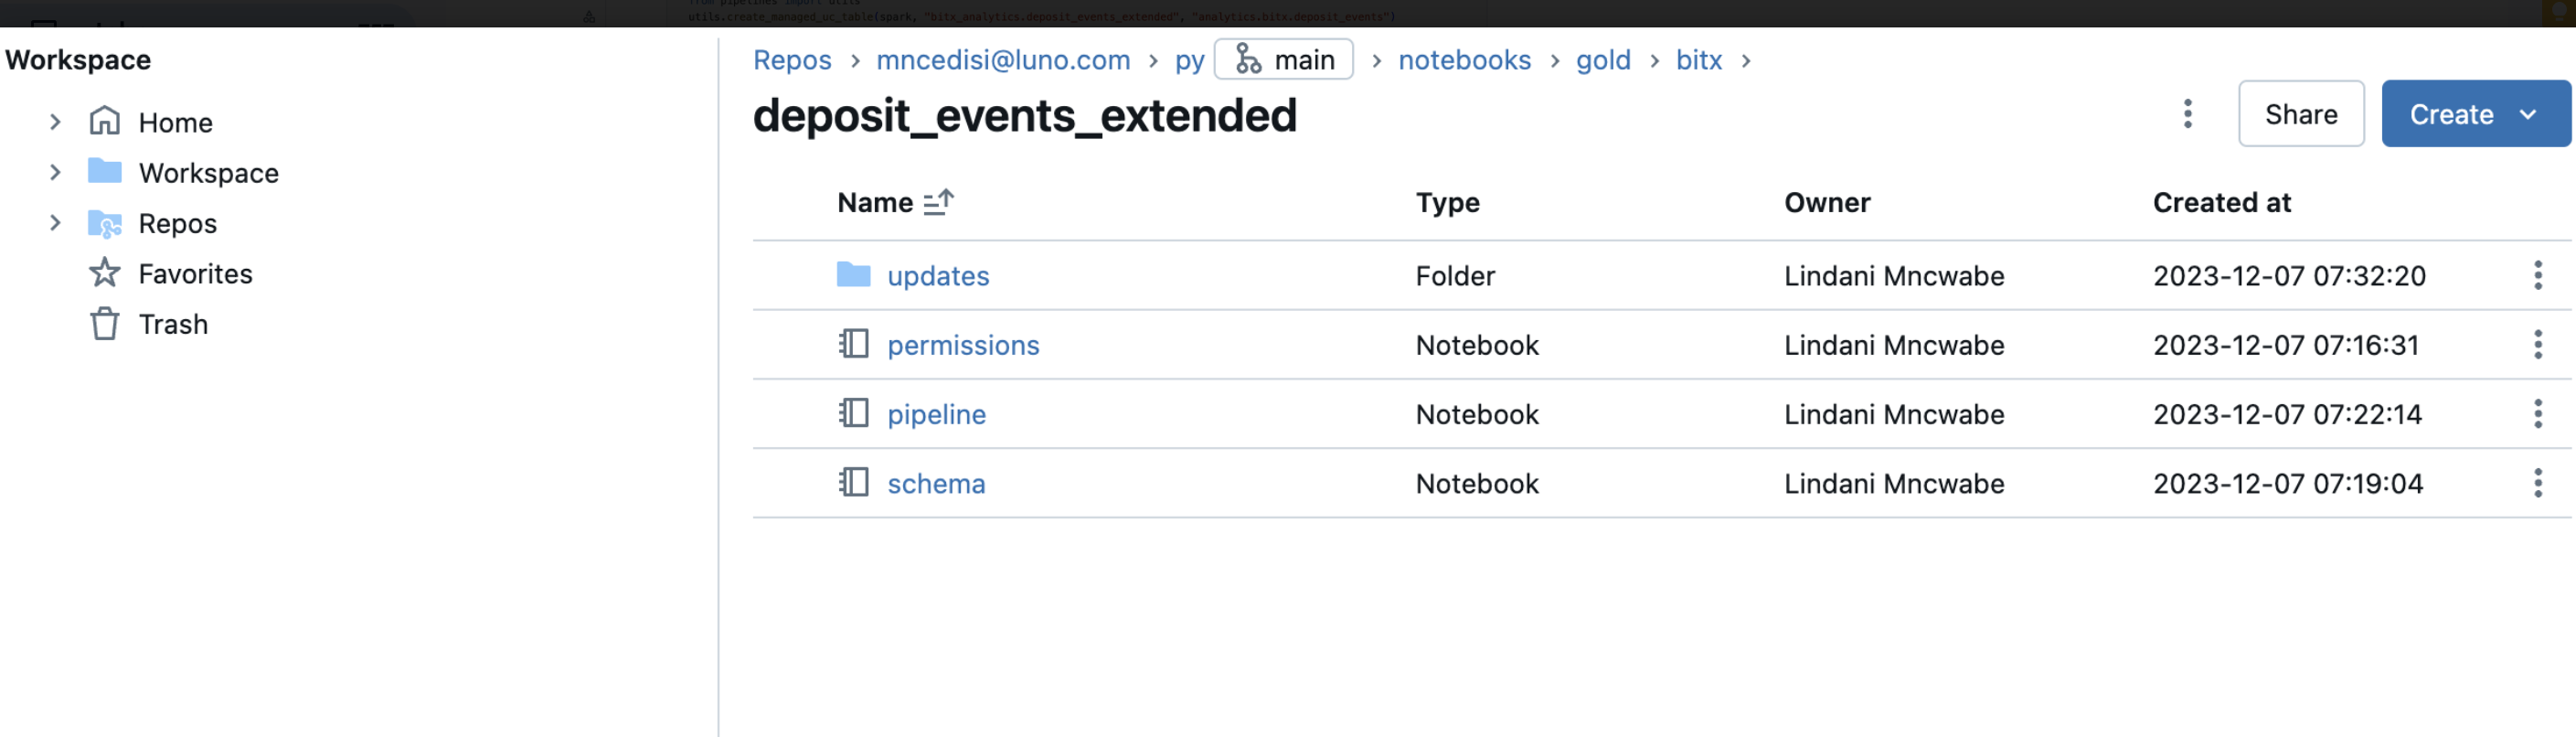

### Create a new table

In [ ]:
-- Pipeline file (will have a job to run and schedule it)
SET spark.databricks.delta.schema.autoMerge.enabled = true;

INSERT OVERWRITE TABLE bitx_analytics.bank_transaction_events_extended
SELECT
      b.id
    , b.foreign_id
    , b.timestamp
    , b.type
    , l1.lookup_name AS type_name 
    FROM bitx_analytics.bank_transaction_events b
    LEFT JOIN bitx_analytics.vw_lookups l1 ON b.type = l1.lookup_enum  AND l1.lookup_type = 'bank_transaction_events_type' 
    ;

In [ ]:
-- Add_schema file (then will have its own job too to run it once)

DROP TABLE IF EXISTS bitx_analytics.bank_transaction_events_extended ;

CREATE TABLE IF NOT EXISTS bitx_analytics.bank_transaction_events_extended  (
      id string
    , foreign_id bigint
    , timestamp timestamp
    , type int
    , type_name string
    )
USING DELTA
  TBLPROPERTIES (
    'delta.autoOptimize.optimizeWrite' = 'true',
    'delta.autoOptimize.autoCompact' = 'true'
  )
;

ALTER TABLE bitx_analytics.bank_transaction_events_extended OWNER TO `super-users`;

In [ ]:

-- Permissions file
ALTER TABLE bitx_analytics.bank_transaction_events_extended OWNER TO `super-users`;

#### Make changes to already existing table

In [ ]:
-- Add_comments file (will also have a once off job to add these column descriptions)
ALTER TABLE bitx_analytics.bank_transaction_events_extended
    ALTER COLUMN id COMMENT "A unique identifier associated with each respective bank transaction event.";

ALTER TABLE bitx_analytics.bank_transaction_events_extended
    ALTER COLUMN foreign_id COMMENT "A unique identifier associated with each bank transaction made.";

ALTER TABLE bitx_analytics.bank_transaction_events_extended
    ALTER COLUMN timestamp COMMENT "The time that the bank transaction event was created.";

ALTER TABLE bitx_analytics.bank_transaction_events_extended
    ALTER COLUMN type COMMENT "Returns the current status number of the bank transactions made.";

ALTER TABLE bitx_analytics.bank_transaction_events_extended
    ALTER COLUMN type_name COMMENT "Returns the status name of the bank transaction when it was created.";

In [ ]:
-- Add_new_field to already existing table without having to rebuild or drop the table (will also need a once-off job to run and add this new field)
-- 1. with this, you first mofify the pipeline file to add that new column to the SELECT statemtne, 
    ---eg. , float(float(payments.fee_e8)/1e8) * nullif(t1.average_price_per_myr,0) AS fee_myr
-- 2. then add the code below add_new_column.sql as a separate sql file
-- 3. then add a job that will run this sql file add_new_column.sql once off

ALTER TABLE bitx_analytics.bank_transaction_events_extended SET TBLPROPERTIES (
   'delta.columnMapping.mode' = 'name',
   'delta.minReaderVersion' = '2',
   'delta.minWriterVersion' = '5');

ALTER TABLE bitx_analytics.bank_transaction_events_extended DROP COLUMNS IF EXISTS fee_myr ;  -- Don't need this line if the column isn't in the existing table

ALTER TABLE bitx_analytics.bank_transaction_events_extended ADD COLUMNS fee_myr DOUBLE AFTER type_name;
